# CIS6800: Final Project Option 1: fine-tune SAM

### Overview:

Segment Anything Model (SAM) https://segment-anything.com/ was really cool on the surface, but you may hate SAM when you actually do research with it. Imagine you are trying to deploy a robot with SAM, but SAM runs 1 sec per 1 image. SAM use ViT backbone and 1024x1024 image as input, the computation cost is 4^4 = 256 times more intense than 224x224 input. Changing ViT input resolution requires fine-tuning. In this project, you will try to fine-tune a low-resolution SAM.

For data, you will use 10k images from SA-1B dataset https://ai.meta.com/datasets/segment-anything/. There will be a mIoU benchmark score, it will evaluate how your model replicate original SAM output down-scaled. The baseline model will be unfreeze the entire SAM, you will try to use LoRA https://arxiv.org/abs/2106.09685 to improve the score.

You will start with a already implemented SAM model as in official repo https://github.com/facebookresearch/segment-anything/tree/main, you will implement the training, evaluation, and modification such as LoRA.

## SAM Introduction

SAM is an interactive segmentation tool. To help understand SAM, first check our their demo https://segment-anything.com/demo#, official github repo https://github.com/facebookresearch/segment-anything/tree/main, code example https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb,

It is highly encouraged for you to review the SAM paper https://arxiv.org/pdf/2304.02643.pdf. However, the main text is filled with marketing stuff, the Appendix is more about implementation details.

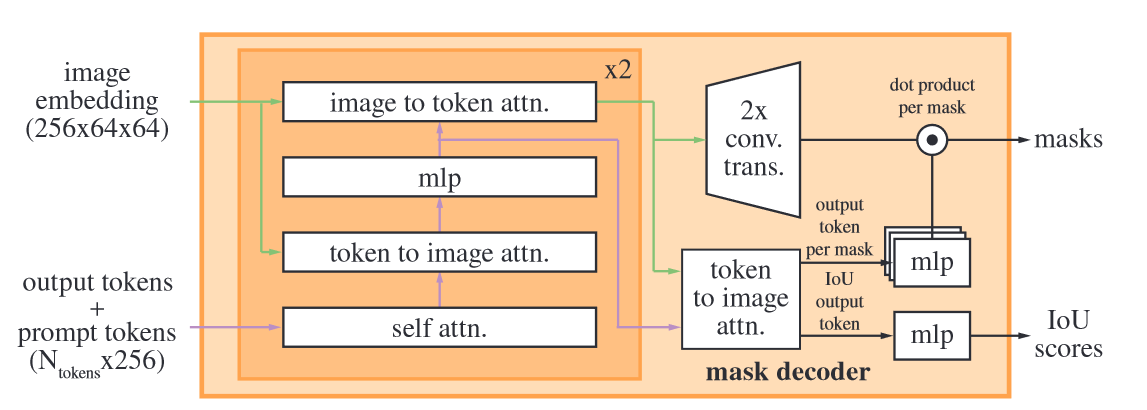

## Data
We provide you with 10k down-sampled images from SA-1B dataset https://ai.meta.com/datasets/segment-anything/



The following code downloads the original dataset, processes it, and visualizes an example.

In [ ]:
# manual download: https://drive.google.com/file/d/1cZIex1MTmsUhwpv5aNeKEWMN4pTbAJcm/view?usp=sharing
!gdown --id 1cZIex1MTmsUhwpv5aNeKEWMN4pTbAJcm
!unzip -o -q sa1b.zip

In [ ]:
!pip install pytorch-lightning pycocotools

In [1]:
import glob
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from PIL import Image

from pycocotools import mask as mask_utils

import json
import numpy as np
from tqdm import tqdm


input_transforms = transforms.Compose([
    transforms.Resize((160, 256)),
    transforms.ToTensor(),
])

target_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((160, 256)),
])

class SA1B_Dataset(torchvision.datasets.ImageFolder):
    """A data loader for the SA-1B Dataset from "Segment Anything" (SAM)
    This class inherits from :class:`~torchvision.datasets.ImageFolder` so
    the same methods can be overridden to customize the dataset.
    Args:
        root (string): Root directory path.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        loader (callable, optional): A function to load an image given its path.
        is_valid_file (callable, optional): A function that takes path of an Image file
            and check if the file is a valid file (used to check of corrupt files)
     Attributes:
        classes (list): List of the class names sorted alphabetically.
        class_to_idx (dict): Dict with items (class_name, class_index).
        imgs (list): List of (image path, class_index) tuples
    """

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        """
        path, _ = self.imgs[index] # discard automatic subfolder labels
        image = self.loader(path)
        masks = json.load(open(f'{path[:-3]}json'))['annotations'] # load json masks
        target = []

        for m in masks:
            # decode masks from COCO RLE format
            target.append(mask_utils.decode(m['segmentation']))
        target = np.stack(target, axis=-1)

        if self.transform is not None:
            image = self.transform(image)
        if self.target_transform is not None:
            target = self.target_transform(target)
        target[target > 0] = 1 # convert to binary masks

        return image, target

    def __len__(self):
        return len(self.imgs)


input_reverse_transforms = transforms.Compose([
    transforms.ToPILImage(),
])

import matplotlib.pyplot as plt
def show_image(image, target, row=12, col=12):
    # image: numpy image
    # target: mask [N, H, W]
    fig, axs = plt.subplots(row, col, figsize=(20, 12))
    for i in range(row):
        for j in range(col):
            if i*row+j < target.shape[0]:
                axs[i, j].imshow(image)
                axs[i, j].imshow(target[i*row+j], alpha=0.5)
            else:
                axs[i, j].imshow(image)
            axs[i, j].axis('off')
    plt.tight_layout()
    plt.show()


/opt/miniconda3/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([3, 160, 256]) torch.Size([45, 160, 256])


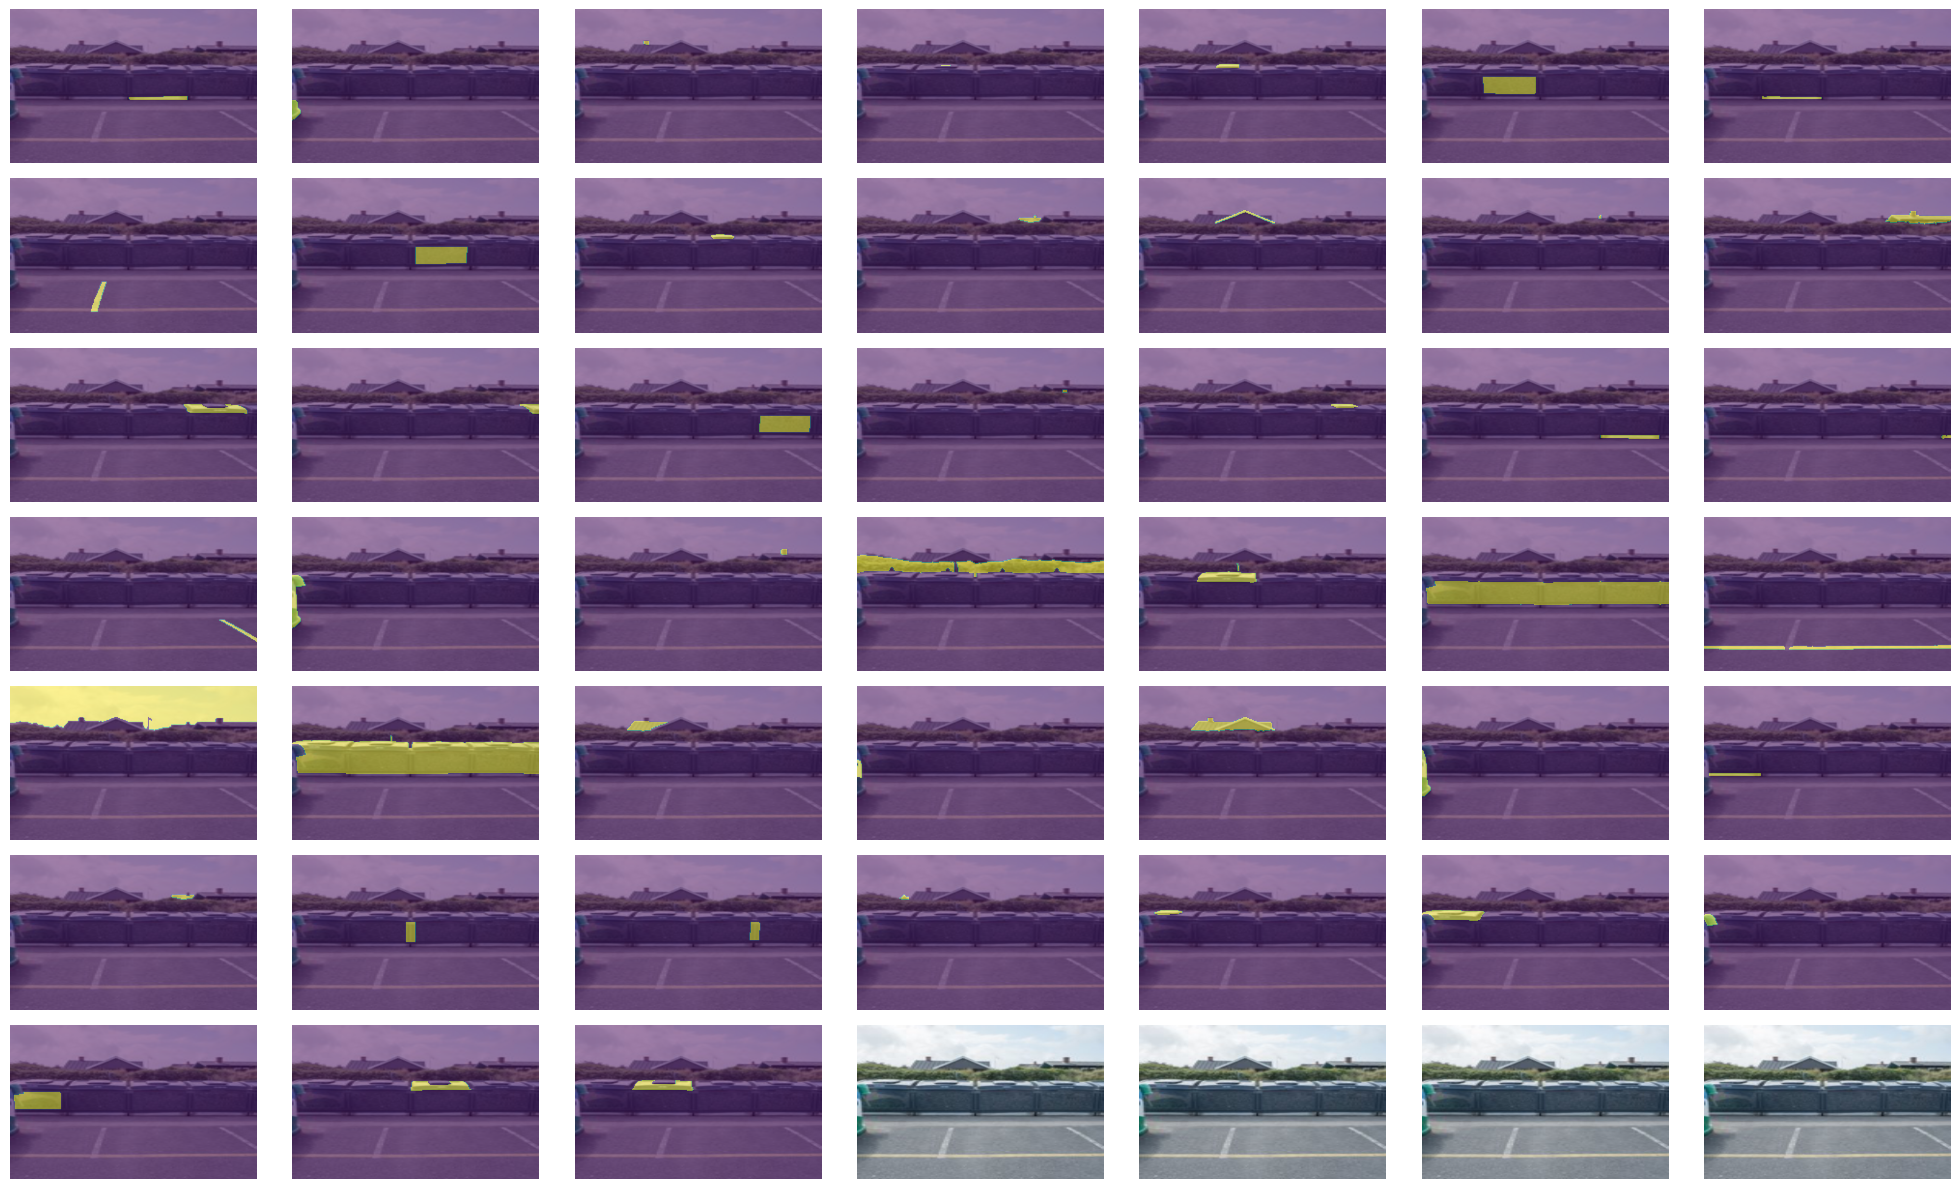

In [2]:
path = './sa1b'
dataset = SA1B_Dataset(path, transform=input_transforms, target_transform=target_transforms)
image, target = dataset.__getitem__(3535)
print(image.shape, target.shape)
image = input_reverse_transforms(image)
image = np.array(image)
show_image(image, target, 7, 7)

## SAM model
You will start from offical SAM implementation, the heavy part is already implementated, but you have to make modification to the model, it's critical to read their code and know how things work. You will need to read through SAM's code starting from https://github.com/facebookresearch/segment-anything/blob/main/segment_anything/modeling/image_encoder.py

For SAM: See Appendix A https://arxiv.org/pdf/2304.02643.pdf

In [6]:
# !pip install git+https://github.com/facebookresearch/segment-anything.git
# you may want to make a local copy instead of pip install,
# as you may need to modify their code
# !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

--2023-11-19 01:18:15--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 2600:9000:25c8:a000:13:6e38:acc0:93a1, 2600:9000:25c8:d400:13:6e38:acc0:93a1, 2600:9000:25c8:6c00:13:6e38:acc0:93a1, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|2600:9000:25c8:a000:13:6e38:acc0:93a1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375042383 (358M) [binary/octet-stream]
Saving to: 'sam_vit_b_01ec64.pth'

sam_vit_b_01ec64.pt 100%[===================>] 357.67M  33.1MB/s    in 10s     

2023-11-19 01:18:25 (35.0 MB/s) - 'sam_vit_b_01ec64.pth' saved [375042383/375042383]



In [3]:
from segment_anything.modeling import ImageEncoderViT
print(ImageEncoderViT().img_size)

1024


In [4]:
from segment_anything import sam_model_registry
sam = sam_model_registry["vit_b"](checkpoint="sam_vit_b_01ec64.pth")

In [5]:
print(ImageEncoderViT().img_size)

1024


In [6]:
print(sam.image_encoder.img_size)

1024


In [7]:
# you need to inject LoRA to Linear(...), Conv2d(...), ConvTranspose2d(...)
print(sam)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


torch.Size([3, 160, 256]) torch.Size([45, 160, 256])


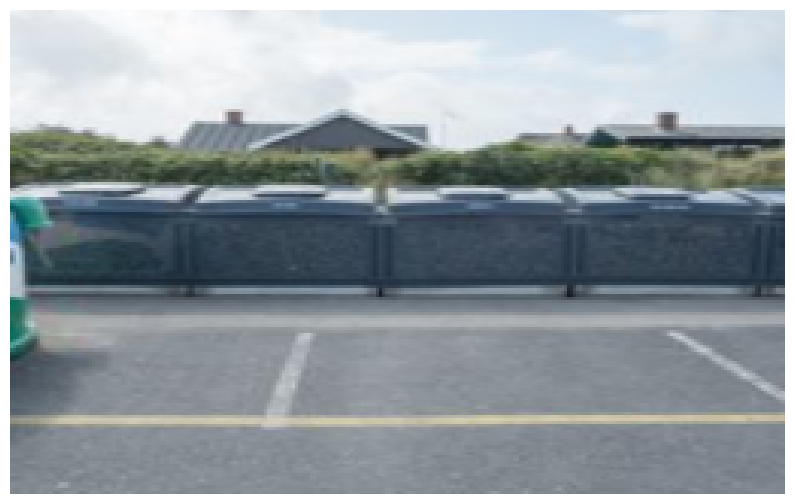

In [8]:
image, target = dataset.__getitem__(3535)
print(image.shape, target.shape)
image = input_reverse_transforms(image)
image = np.array(image)
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('off')
plt.show()

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sam = sam.to(device=device)

### Bypass SamPredictor's code to pass low-resolution input.

In [11]:
from segment_anything import SamPredictor
from segment_anything.modeling import ImageEncoderViT, PromptEncoder

sam_checkpoint = "sam_vit_b_01ec64.pth"
model_type = "vit_b"

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
# sam.image_encoder = ImageEncoderViT(img_size=256)
# sam.prompt_encoder = PromptEncoder(embed_dim=256, input_image_size=(256, 256), image_embedding_size=(16, 16), mask_in_chans=16)
sam.to(device=device)
sam.image_encoder.img_size = 256

In [12]:
sam.image_encoder.img_size

256

In [13]:
sam.image_encoder.pos_embed.data.shape

torch.Size([1, 64, 64, 768])

In [14]:
# Define an average pooling layer
avg_pooling = nn.AvgPool2d(kernel_size=4, stride=4)

# Apply average pooling to downsample the tensor
downsampled_tensor = avg_pooling(sam.image_encoder.pos_embed.permute(0,3,1,2)).permute(0,2,3,1)

In [15]:
downsampled_tensor.shape

torch.Size([1, 16, 16, 768])

In [16]:
sam.image_encoder.pos_embed.data = downsampled_tensor

In [47]:
sam.prompt_encoder.input_image_size = [256,256]

In [48]:
sam.prompt_encoder.image_embedding_size = [16,16]

In [49]:
predictor = SamPredictor(sam)

In [18]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 1])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

In [50]:
predictor.set_image(image)

In [59]:
print(image.shape)
input_point = np.array([image.shape[:2]]) / 3
input_label = np.array([1])
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

(160, 256, 3)
torch.Size([1, 256, 16, 16])
torch.Size([1, 256, 16, 16])


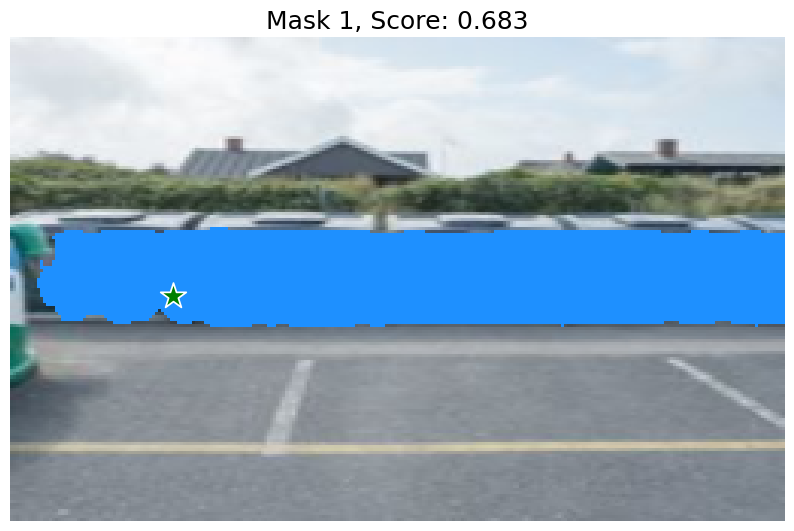

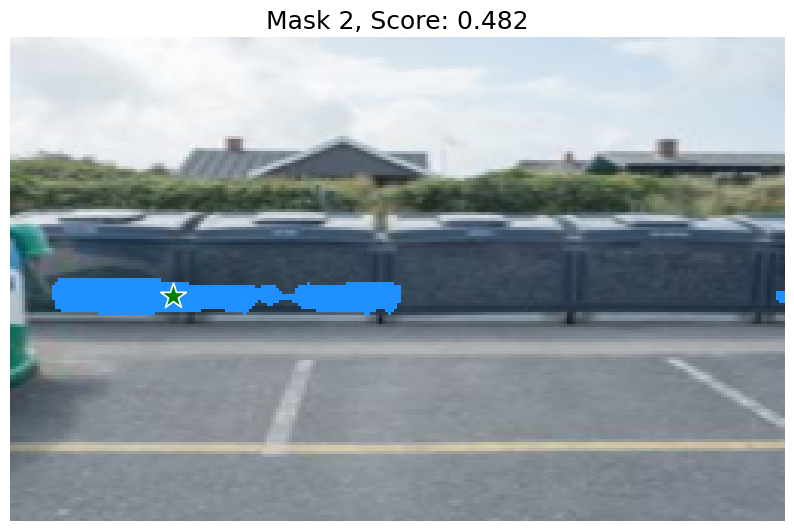

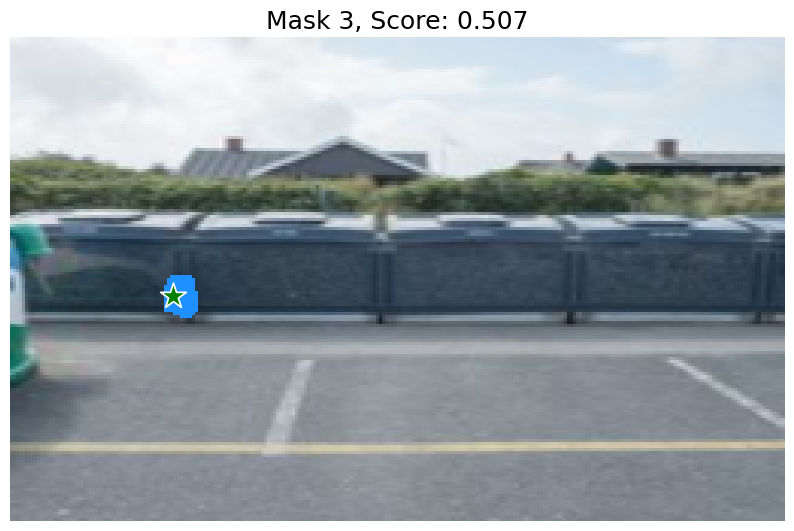

In [60]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  

In [56]:
input_point = np.array([[20,20], [20,50]])
input_label = np.array([1, 0])

mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask

In [57]:
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

torch.Size([1, 256, 16, 16])
torch.Size([1, 256, 16, 16])


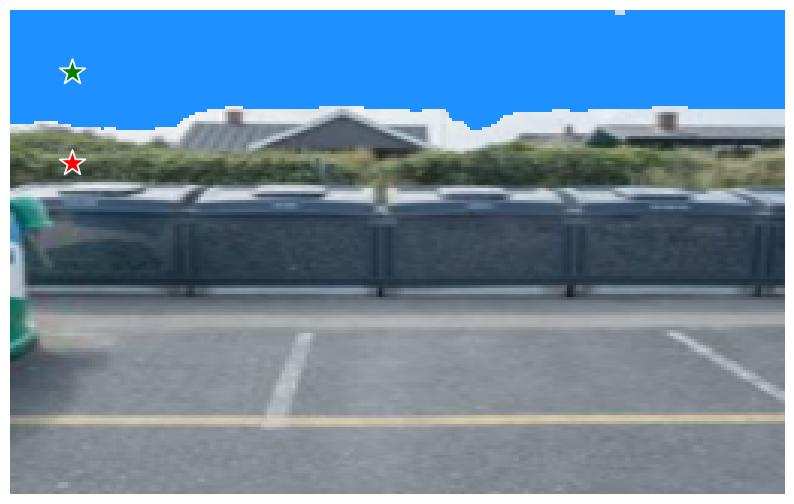

In [58]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show() 

In [64]:
input_box = np.array([60, 70, 110, 90])

In [65]:
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

torch.Size([1, 256, 16, 16])
torch.Size([1, 256, 16, 16])


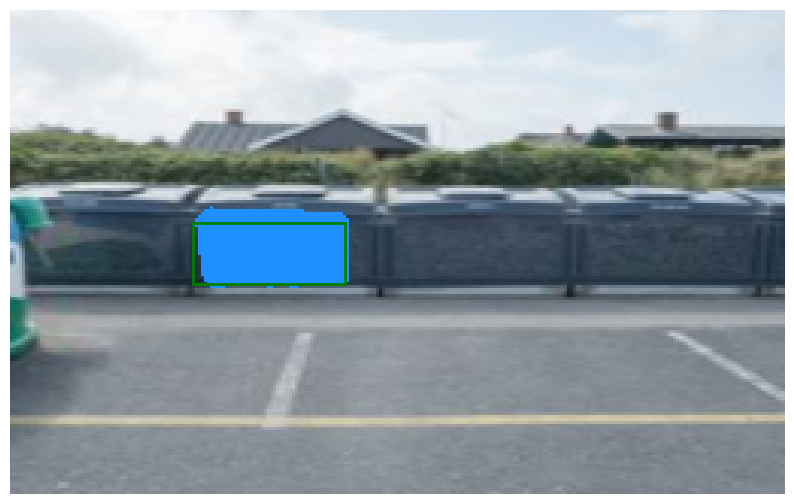

In [66]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()


## Results (in your report)
1. show the output of original sam model (not fine-tuned) bullied to low-resolution, compare to the original sam at high-resolution (upscale the low-resolution image back to 1600x2560).

Hint: Example code from https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb will always rescale the input to 1024x1024 before passing to sam encoder, you need to modify and bypass SamPredictor's code to pass low-resolution input. In particular, wrong shape of positional encoding will raise error on every attention layer, you will need to either 1) downsample existing PE in every layer or 2) re-initilize PE to the low-resolution shape

2. disccuss the difficulty in applying sam to low resolution input. why fine-tuning is needed, what's the alternative solution.

Hint: start from positional encoding, patchfy operation, first convolution layer, are they scale invariant? why and why not.



## LoRA module
We also provide you an toy example of LoRA module injected into any nn.Linear class. You will implement similar LoRA class for Conv2D and ConvTranspose2d.

For LoRA: https://arxiv.org/abs/2106.09685

In [ ]:
# !pip install timm

In [68]:
class LoRALinearLayer(nn.Module):
    def __init__(self, in_features, out_features, rank=4):
        super().__init__()

        if rank > min(in_features, out_features):
            raise ValueError(
                f"LoRA rank {rank} must be less or equal than {min(in_features, out_features)}"
            )

        self.down = nn.Linear(in_features, rank, bias=False)
        self.up = nn.Linear(rank, out_features, bias=False)

        nn.init.normal_(self.down.weight, std=1 / rank)
        nn.init.zeros_(self.up.weight)

    def forward(self, hidden_states):
        orig_dtype = hidden_states.dtype
        dtype = self.down.weight.dtype

        down_hidden_states = self.down(hidden_states.to(dtype))
        up_hidden_states = self.up(down_hidden_states)

        return up_hidden_states.to(orig_dtype)

    @property
    def weight(self):
        return self.up.weight @ self.down.weight

    @property
    def bias(self):
        return 0

class MonkeyPatchLoRALinear(nn.Module):
    # It's "monkey patch" means you can replace nn.Linear with the new
    # LoRA Linear class without modifying any other code.
    def __init__(self, fc: nn.Linear, rank=4, lora_scale=1):
        super().__init__()
        if rank > min(fc.in_features, fc.out_features):
            raise ValueError(
                f"LoRA rank {rank} must be less or equal than {min(fc.in_features, fc.out_features)}"
            )
        if not isinstance(fc, nn.Linear):
            raise ValueError(
                f"MonkeyPatchLoRALinear only support nn.Linear, but got {type(fc)}"
            )

        self.fc = fc
        self.rank = rank
        self.lora_scale = lora_scale

        in_features = fc.in_features
        out_features = fc.out_features
        self.fc_lora = LoRALinearLayer(in_features, out_features, rank)

    def forward(self, hidden_states: torch.Tensor) -> torch.Tensor:
        hidden_states = self.fc(hidden_states) + \
                        self.lora_scale * self.fc_lora(hidden_states)
        return hidden_states

    @property
    def weight(self):
        return self.fc.weight + self.lora_scale * self.fc_lora.weight

    @property
    def bias(self):
        return self.fc.bias

# your implementation

class LoRAConv2DLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, rank=4):
            super().__init__()

            if rank > min(in_channels * kernel_size**2, out_channels):
                raise ValueError(
                    f"LoRA rank {rank} must be less or equal than {min(in_channels * kernel_size**2, out_channels)}"
                )

            self.down = nn.Conv2d(in_channels, rank, kernel_size, stride, padding, bias=False)
            self.up = nn.Conv2d(rank, out_channels, 1, 1, 0, bias=False)

            nn.init.normal_(self.down.weight, std=1 / rank)
            nn.init.zeros_(self.up.weight)

    def forward(self, hidden_states):
        orig_dtype = hidden_states.dtype
        dtype = self.down.weight.dtype

        down_hidden_states = F.conv2d(hidden_states.to(dtype), self.down.weight, self.down.bias, self.down.stride, self.down.padding)
        up_hidden_states = F.conv2d(down_hidden_states, self.up.weight, self.up.bias, self.up.stride, self.up.padding)

        return up_hidden_states.to(orig_dtype)
    
    @property
    def weight(self):
        return self.up.weight @ self.down.weight

    @property
    def bias(self):
        return 0

class MonkeyPatchLoRAConv2D(nn.Module):
    def __init__(self, conv2d: nn.Conv2d, rank=4, lora_scale=1):
        super().__init__()
        if rank > min(conv2d.in_channels * conv2d.kernel_size[0]**2, conv2d.out_channels):
            raise ValueError(
                f"LoRA rank {rank} must be less or equal than {min(conv2d.in_channels * conv2d.kernel_size[0]**2, conv2d.out_channels)}"
            )
        if not isinstance(conv2d, nn.Conv2d):
            raise ValueError(
                f"MonkeyPatchLoRAConv2D only supports nn.Conv2d, but got {type(conv2d)}"
            )

        self.conv2d = conv2d
        self.rank = rank
        self.lora_scale = lora_scale

        in_channels = conv2d.in_channels
        out_channels = conv2d.out_channels
        kernel_size = conv2d.kernel_size
        stride = conv2d.stride
        padding = conv2d.padding
        self.conv2d_lora = LoRAConv2DLayer(in_channels, out_channels, kernel_size, stride, padding, rank)

    def forward(self, hidden_states: torch.Tensor) -> torch.Tensor:
        hidden_states = self.conv2d(hidden_states) + \
                        self.lora_scale * self.conv2d_lora(hidden_states)
        return hidden_states

    @property
    def weight(self):
        return self.conv2d.weight + self.lora_scale * self.conv2d_lora.weight

    @property
    def bias(self):
        return self.conv2d.bias

class LoRAConvTranspose2DLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0, rank=4):
        super().__init__()

        if rank > min(in_channels, out_channels * kernel_size**2):
            raise ValueError(
                f"LoRA rank {rank} must be less or equal than {min(in_channels, out_channels * kernel_size**2)}"
            )

        # Define the downsample convolution layer
        self.down = nn.ConvTranspose2d(in_channels, rank, kernel_size, stride, padding, output_padding, bias=False)
        
        # Define the upsample convolution layer
        self.up = nn.ConvTranspose2d(rank, out_channels, 1, 1, 0, bias=False)

        # Initialize weights
        nn.init.normal_(self.down.weight, std=1 / rank)
        nn.init.zeros_(self.up.weight)

    def forward(self, hidden_states):
        orig_dtype = hidden_states.dtype
        dtype = self.down.weight.dtype

        # Perform the downsample convolution
        down_hidden_states = F.conv_transpose2d(hidden_states.to(dtype), self.down.weight, self.down.bias, self.down.stride, self.down.padding, self.down.output_padding)
        
        # Perform the upsample convolution
        up_hidden_states = F.conv_transpose2d(down_hidden_states, self.up.weight, self.up.bias, self.up.stride, self.up.padding, self.up.output_padding)

        return up_hidden_states.to(orig_dtype)

    @property
    def weight(self):
        return self.up.weight @ self.down.weight

    @property
    def bias(self):
        return 0


class MonkeyPatchLoRAConvTranspose2D(nn.Module):
    def __init__(self, conv_transpose2d: nn.ConvTranspose2d, rank=4, lora_scale=1):
        super().__init__()
        if rank > min(conv_transpose2d.in_channels, conv_transpose2d.out_channels * conv_transpose2d.kernel_size[0]**2):
            raise ValueError(
                f"LoRA rank {rank} must be less or equal than {min(conv_transpose2d.in_channels, conv_transpose2d.out_channels * conv_transpose2d.kernel_size[0]**2)}"
            )
        if not isinstance(conv_transpose2d, nn.ConvTranspose2d):
            raise ValueError(
                f"MonkeyPatchLoRAConvTranspose2D only supports nn.ConvTranspose2d, but got {type(conv_transpose2d)}"
            )

        # Save the original ConvTranspose2D layer
        self.conv_transpose2d = conv_transpose2d
        self.rank = rank
        self.lora_scale = lora_scale

        # Create the LoRA ConvTranspose2D layer
        in_channels = conv_transpose2d.in_channels
        out_channels = conv_transpose2d.out_channels
        kernel_size = conv_transpose2d.kernel_size
        stride = conv_transpose2d.stride
        padding = conv_transpose2d.padding
        output_padding = conv_transpose2d.output_padding
        self.conv_transpose2d_lora = LoRAConvTranspose2DLayer(in_channels, out_channels, kernel_size, stride, padding, output_padding, rank)

    def forward(self, hidden_states: torch.Tensor) -> torch.Tensor:
        # Forward pass using both the original ConvTranspose2D and LoRA ConvTranspose2D
        hidden_states = self.conv_transpose2d(hidden_states) + \
                        self.lora_scale * self.conv_transpose2d_lora(hidden_states)
        return hidden_states

    @property
    def weight(self):
        # Combine weights of the original ConvTranspose2D and LoRA ConvTranspose2D
        return self.conv_transpose2d.weight + self.lora_scale * self.conv_transpose2d_lora.weight

    @property
    def bias(self):
        # Return the bias of the original ConvTranspose2D
        return self.conv_transpose2d.bias

In [69]:
# MLP toy example of LoRA

from timm.layers.mlp import Mlp

mlp = Mlp(768)
print(mlp)

def freeze(module):
    from pytorch_lightning.callbacks.finetuning import BaseFinetuning
    BaseFinetuning.freeze(module, train_bn=True)

freeze(mlp)

Mlp(
  (fc1): Linear(in_features=768, out_features=768, bias=True)
  (act): GELU(approximate='none')
  (drop1): Dropout(p=0.0, inplace=False)
  (norm): Identity()
  (fc2): Linear(in_features=768, out_features=768, bias=True)
  (drop2): Dropout(p=0.0, inplace=False)
)


In [70]:
def print_params(model):
  model_parameters = filter(lambda p: True, model.parameters())
  params = sum([np.prod(p.size()) for p in model_parameters])
  print("total params: ", params)
  model_parameters = filter(lambda p: p.requires_grad, model.parameters())
  params = sum([np.prod(p.size()) for p in model_parameters])
  print("training params: ", params)

In [71]:
print_params(mlp)

total params:  1181184
training params:  0


In [72]:
# inject LoRA
for name, block in mlp.named_children():
    # patch every nn.Linear
    if isinstance(block, nn.Linear):
      block = MonkeyPatchLoRALinear(block, 4, 1)
      setattr(mlp, name, block)

In [73]:
print(mlp)

Mlp(
  (fc1): MonkeyPatchLoRALinear(
    (fc): Linear(in_features=768, out_features=768, bias=True)
    (fc_lora): LoRALinearLayer(
      (down): Linear(in_features=768, out_features=4, bias=False)
      (up): Linear(in_features=4, out_features=768, bias=False)
    )
  )
  (act): GELU(approximate='none')
  (drop1): Dropout(p=0.0, inplace=False)
  (norm): Identity()
  (fc2): MonkeyPatchLoRALinear(
    (fc): Linear(in_features=768, out_features=768, bias=True)
    (fc_lora): LoRALinearLayer(
      (down): Linear(in_features=768, out_features=4, bias=False)
      (up): Linear(in_features=4, out_features=768, bias=False)
    )
  )
  (drop2): Dropout(p=0.0, inplace=False)
)


In [74]:
print(mlp.fc1.fc.weight.requires_grad) # load this from trained model, freeze
print(mlp.fc1.fc_lora.weight.requires_grad) # LoRA initilized, do not freeze

False
True


In [75]:
print_params(mlp)

total params:  1193472
training params:  12288


In [76]:
print(sam)
freeze(sam)
print_params(sam)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


In [83]:
for name, block in sam.image_encoder.named_children():
    # patch every nn.Linear in Mlp
    if isinstance(block, nn.Linear):
      block = MonkeyPatchLoRALinear(block, 4, 1)
      setattr(sam.image_encoder, name, block)

In [84]:
print(sam)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


In [79]:
print_params(mlp)

total params:  1193472
training params:  12288


## Methods and Results (in your report)

1. how do you implement LoRA, which part of SAM model do you fine-tune?
2. summarize number of parameters before and after LoRA
3. compare training results of completely unfreeze SAM v.s. LoRA.

## SAM target assignment

Take a closer look at the data, there's some big mask containing small masks. the SAM model will predict 3 output masks (with 3 confidence score) for a single prompt, 3 mask outputs is ordered from big to small objects. You will need to implement function to sample these 3 masks from masks of one image in SA-1B dataset.

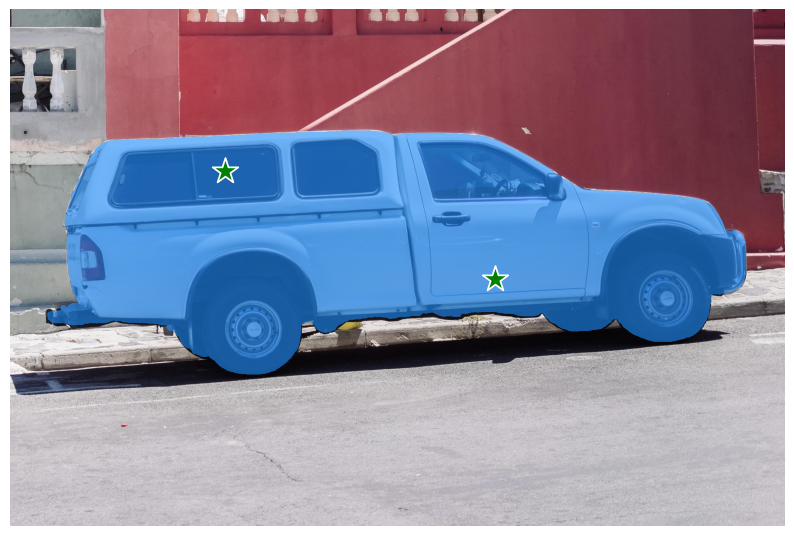

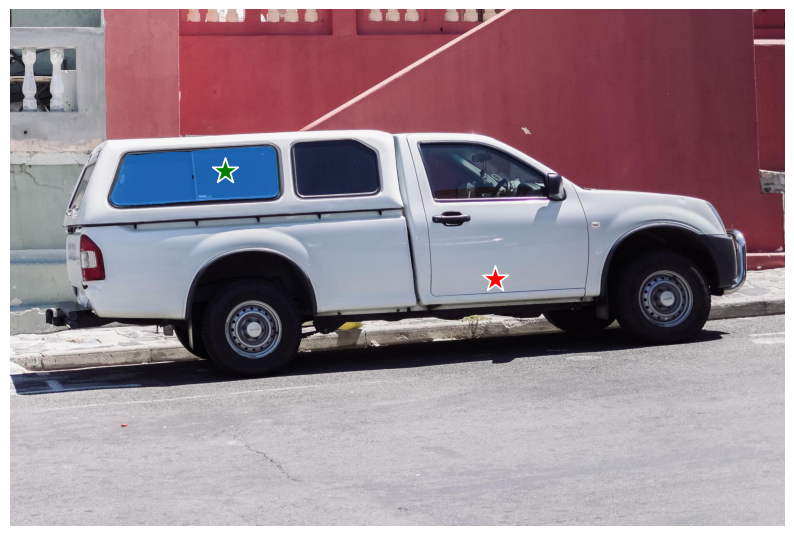

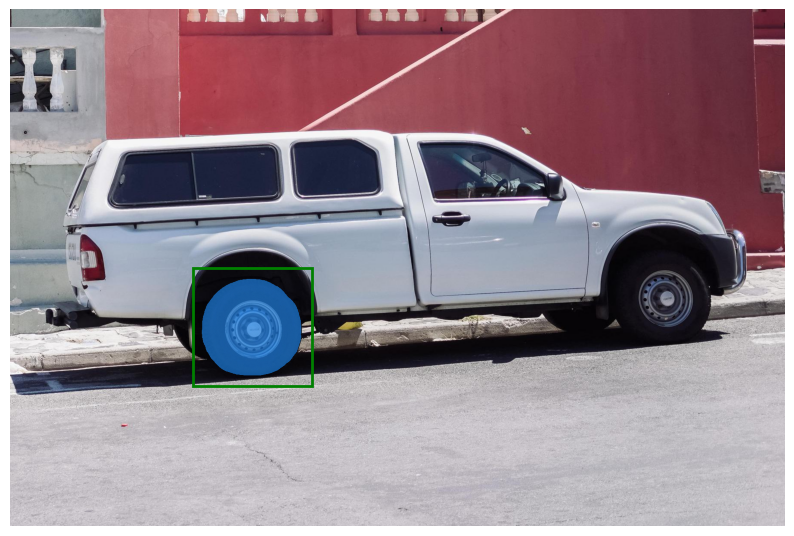

In [ ]:
def point_sample(all_masks, points_coords, points_label):
    # all_masks: [N, H, W], one image, N masks
    # points_coords: (N, 2)
    # points_label: (N, 1), 1 for foreground, 0 for background
    # return: sampled_masks: [3, H, W], masks order from big to small
    # you can modify the signature of this function
    ...

def box_sample(all_masks, bbox):
    # all_masks: [N, H, W], one image, N masks
    # bbox: (xxyy)
    # return: sampled_masks: [3, H, W], masks order from big to small
    # you can modify the signature of this function
    ...

# you don't need to implement the case with both points and box

## Visulize (in your report)

show the returned 3 masks, ordered from big to small

show `point_sample()` with 1. one positive point, 2. one positive and one negative point. 3. multiple points with both positive and negative

show `box_sample()` with 1. one positive box

## Training
as described in SAM paper Section 3 and Appendix A. You simulate an interactive segmentation setup during training: you need to implement 1a. single point prompt training 1b. iterative training up to 3 iteration 2. box prompt training, only 1 iteration;

### 1a and 2: one iteration training
First, with equal probability either a foreground point
or bounding box is selected randomly for the target mask.
Points are sampled uniformly from the ground truth mask.
Boxes are taken as the ground truth mask’s bounding box,
with random noise added in each coordinate with standard
deviation equal to 10% of the box sidelength, to a maximum of 20 pixels.

### 1b: three iteration training
After making a prediction from this first prompt, subsequent points are selected uniformly from the error region
between the previous mask prediction and the ground truth
mask. Each new point is foreground or background if the error region is a false negative or false positive, respectively.
We also supply the mask prediction from the previous iteration as an additional prompt to our model. To provide
the next iteration with maximal information, we supply the
unthresholded mask logits instead of the binarized mask.
When multiple masks are returned, the mask passed to the
next iteration and used to sample the next point is the one
with the highest predicted IoU.

- You do not need to implement text prompt as there's no text data in SA-1B dataset

In [ ]:
from segment_anything.modeling.sam import Sam
import pytorch_lightning as pl


class MyFastSAM(pl.LightningModule):
    def __init__(self, orig_sam: Sam, lora_rank: int, lora_scale: float):
        super().__init__()
        self.lora_sam = ...

    def forward(self, *args, **kwargs):
        """
        comments imported from original SAM code

        Arguments:
          batched_input (list(dict)): A list over input images, each a
            dictionary with the following keys. A prompt key can be
            excluded if it is not present.
              'image': The image as a torch tensor in 3xHxW format,
                already transformed for input to the model.
              'original_size': (tuple(int, int)) The original size of
                the image before transformation, as (H, W).
              'point_coords': (torch.Tensor) Batched point prompts for
                this image, with shape BxNx2. Already transformed to the
                input frame of the model.
              'point_labels': (torch.Tensor) Batched labels for point prompts,
                with shape BxN.
              'boxes': (torch.Tensor) Batched box inputs, with shape Bx4.
                Already transformed to the input frame of the model.
              'mask_inputs': (torch.Tensor) Batched mask inputs to the model,
                in the form Bx1xHxW.
          multimask_output (bool): Whether the model should predict multiple
            disambiguating masks, or return a single mask.

        Returns:
          (list(dict)): A list over input images, where each element is
            as dictionary with the following keys.
              'masks': (torch.Tensor) Batched binary mask predictions,
                with shape BxCxHxW, where B is the number of input prompts,
                C is determined by multimask_output, and (H, W) is the
                original size of the image.
              'iou_predictions': (torch.Tensor) The model's predictions
                of mask quality, in shape BxC.
              'low_res_logits': (torch.Tensor) Low resolution logits with
                shape BxCxHxW, where H=W=256. Can be passed as mask input
                to subsequent iterations of prediction.
        """
        return self.lora_sam(...)

    def configure_optimizers(self):
        lora_parameters = [param for param in self.parameters() if param.requires_grad]
        # make sure original sam don't requires_grad
        optimizer = torch.optim.AdamW(lora_parameters, lr=1e-5)
        return optimizer

    @staticmethod
    def mask_dice_loss(prediction, targets):
        ...

    @staticmethod
    def mask_focal_loss(prediction, targets):
        ...

    @staticmethod
    def iou_token_loss(iou_prediction, prediction, targets):
        ...

    def training_step(self, batch, batch_idx):
        images, targets = batch
        batched_input = self.construct_batched_input(...)
        # 1a. single point prompt training
        # 1b. iterative point prompt training up to 3 iteration
        # 2. box prompt training, only 1 iteration
        predictions = self.forward(batched_input)
        loss = ...
        self.log('train_loss', loss, prog_bar=True)
        # During training, we backprop only the minimum loss over the 3 output masks.
        # sam paper main text Section 3
        return loss

    def validation_step(self, batch, batch_idx):
        images, targets = batch
        ...
        loss = ...
        # use same procedure as training, monitor the loss
        self.log('val_loss', loss, prog_bar=True)

## Results (in your report)

1. show the process of sampling points in multiple iteration training, how the GT mask is assigned in each iteration
1. show training / validation loss curve, for each loss and sum of all losses.
1. besides loss, think about metrics such as mIoU, mAP, how to implement them in the sam's setting, or why not to implement each metrics, what make them unsuitable for sam's task? Remember: 1) we only have masks without category 2) sam need prompts.
1. on your trained model, cherry pick good examples, but also pick bad examples, rescale the input image back to 1024x1024 pixels, pass them to the original SAM model with the original pipeline, compare to your low-resolution LoRA results, disccuss what make them good or bad.